In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
isee_machine = pd.read_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label.csv')

- df: 'PL04496-03040' 제품만 대상으로

In [3]:
prod_list = isee_machine['ProductNum'].unique()
df = isee_machine[isee_machine['ProductNum']==prod_list[0]]

- prop: 이상 비율 설정

In [4]:
prop = df['NG'].sum()/len(df)

In [5]:
analy_col = [ 'CycleTime', 'VpPosition', 'VpTime',
       'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
       'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
       'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
       'Zone1', 'Zone2', 'Zone3', 'Zone4']

analy_df = df[analy_col]
scaled_X = RobustScaler().fit_transform(analy_df)
scaled_df = pd.DataFrame(scaled_X, index=analy_df.index, columns=analy_df.columns)

### Kmeans

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Inertia value를 이용한 적정 군집 수 판단. inertia_:가장 가까운 클러스터의 중심과 각 샘플의 거리 제곱 합

In [7]:
ks = range(1,10)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_X)
    inertias.append(kmeans.inertia_)

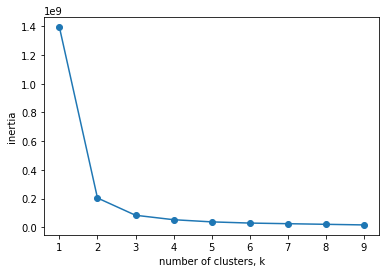

In [8]:
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [9]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_X)

In [10]:
y_pred = kmeans.predict(scaled_X)

In [11]:
scaled_df['Kmeans_label'] = y_pred

In [12]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

df2 = pd.DataFrame(columns=analy_col+['md'])
k_list= scaled_df['Kmeans_label'].unique()
for cy in k_list:
    temp_df = scaled_df[scaled_df.Kmeans_label==cy][analy_col]
    robust_cov = MinCovDet().fit(temp_df)
    m = robust_cov.mahalanobis(temp_df)
    temp_df['md'] = m
    df2 = pd.concat([df2,temp_df], axis=0)

C:\Users\ARA\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
C:\Users\ARA\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


In [13]:
df2 = df2.sort_index()

In [14]:
k = sorted(df2.md.values, reverse=True)
t = np.ceil(len(df2.md.values)*prop).astype(int)

In [15]:
mahala_label = []
for x in df2.md.values:
    if x< k[t]: mahala_label.append(0)
    #elif 50<= x < 200 : mahala_label.append(1)
    else: mahala_label.append(1)

df['K_mahala_label'] = mahala_label

C:\Users\ARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### MCD

In [16]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
 
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(scaled_df)
 
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(scaled_df)

In [17]:
k = sorted(m.tolist(), reverse=True)
t = np.ceil(len(m)*prop).astype(int)

In [18]:
mahala_label = []
for x in m:
    if x< k[t]: mahala_label.append(0)
    #elif 50<= x < 200 : mahala_label.append(1)
    else: mahala_label.append(1)

df['mahala_label'] = mahala_label

C:\Users\ARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


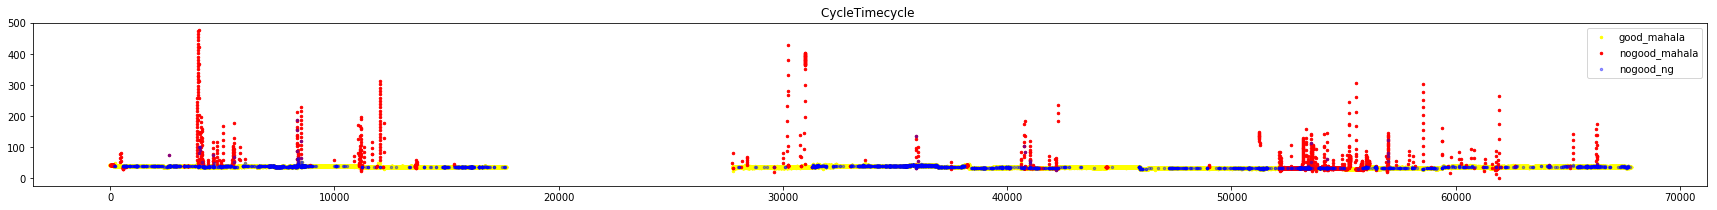

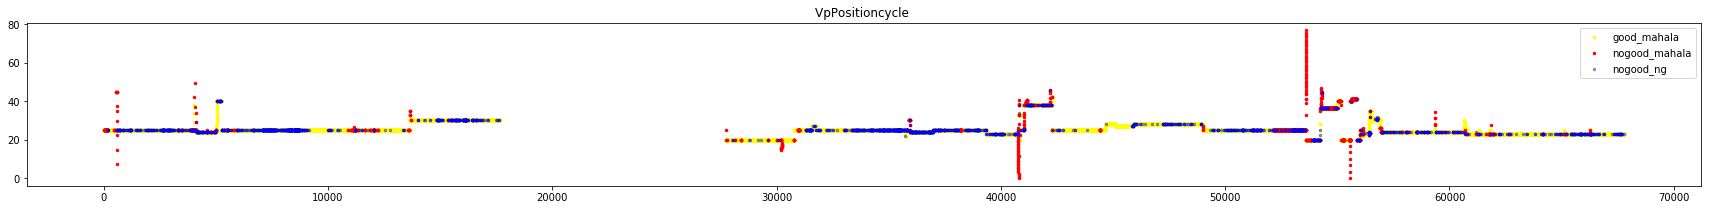

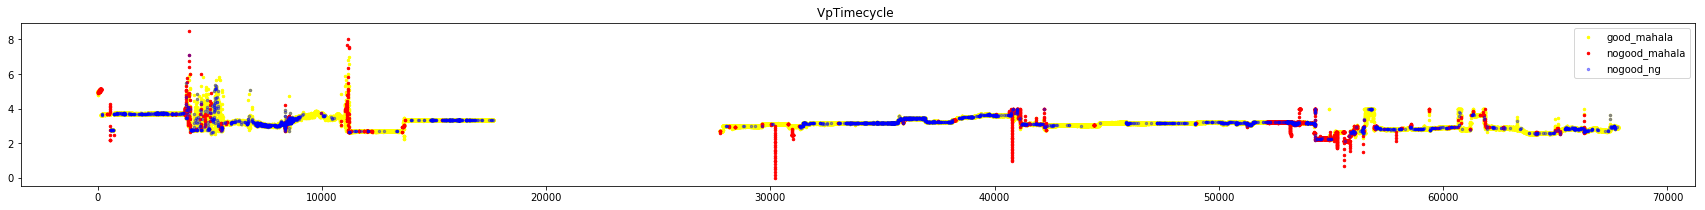

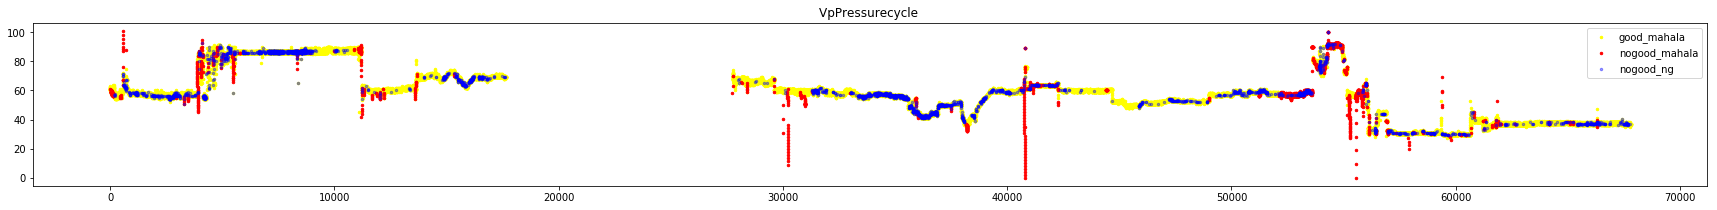

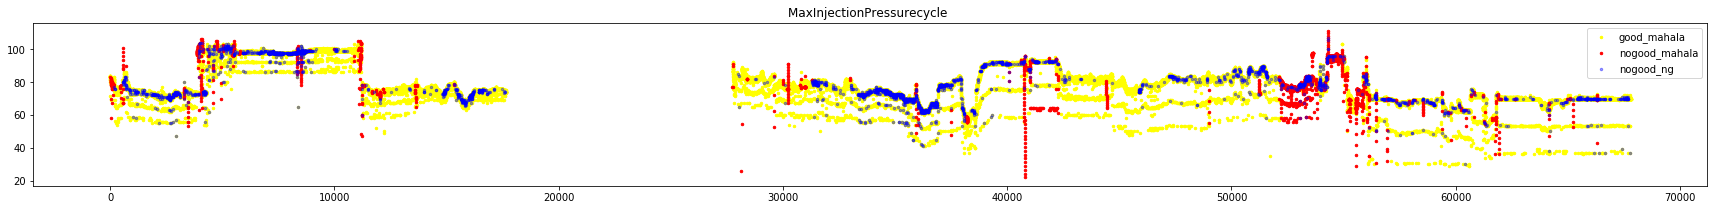

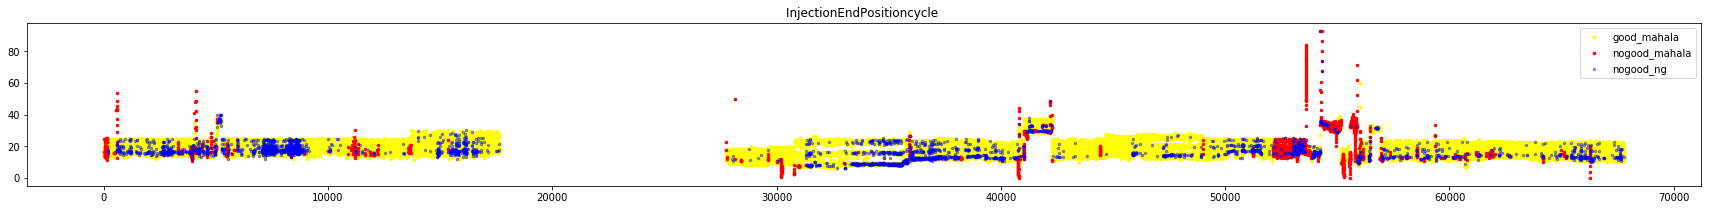

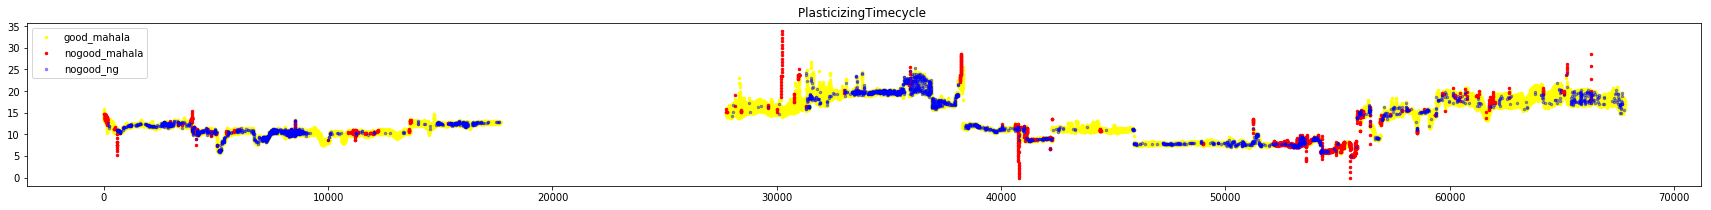

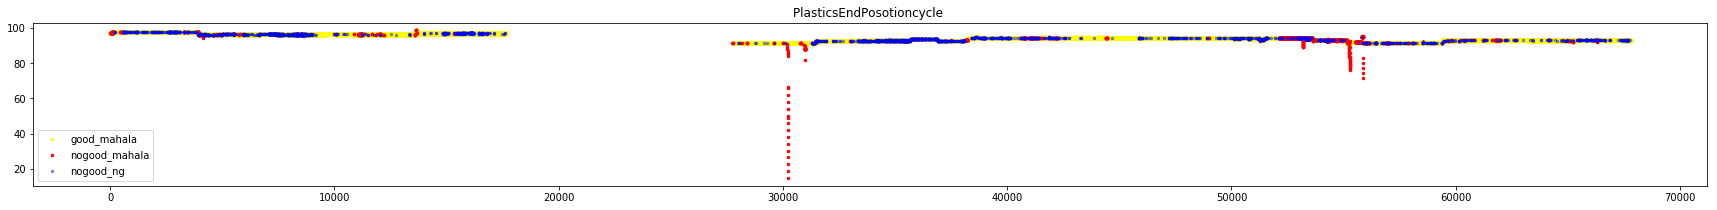

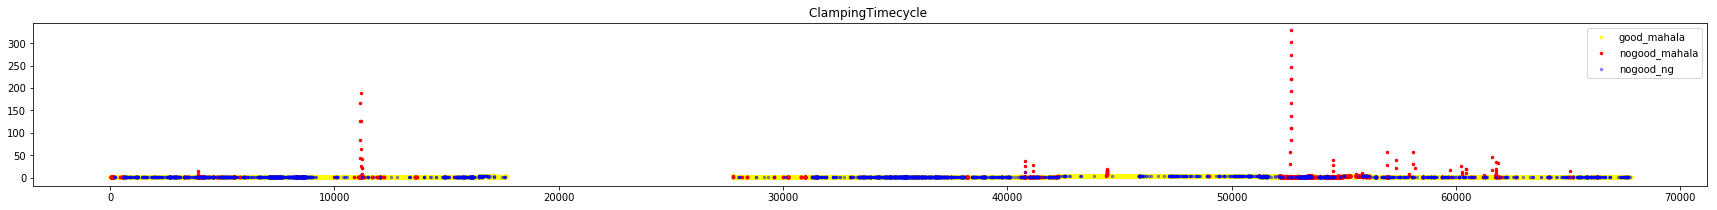

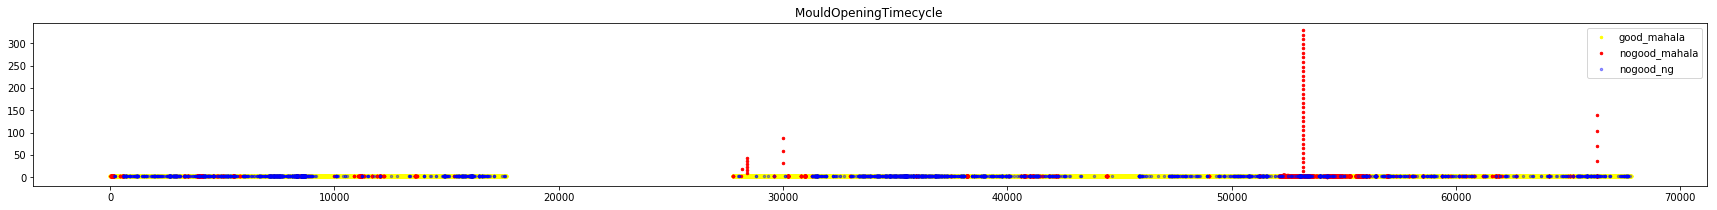

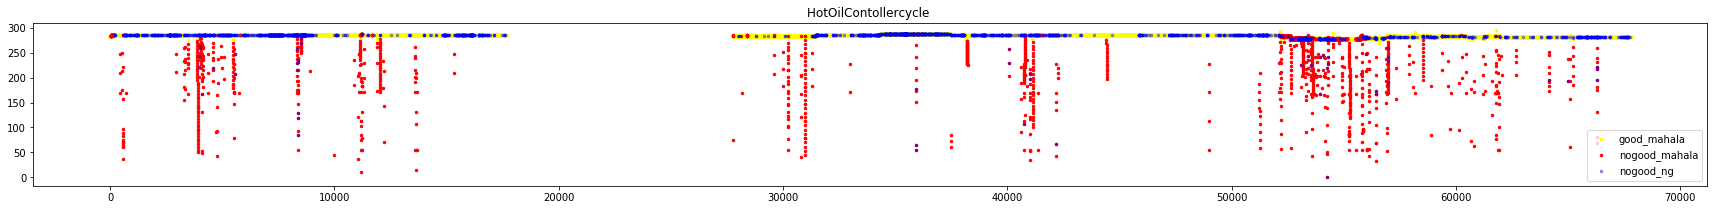

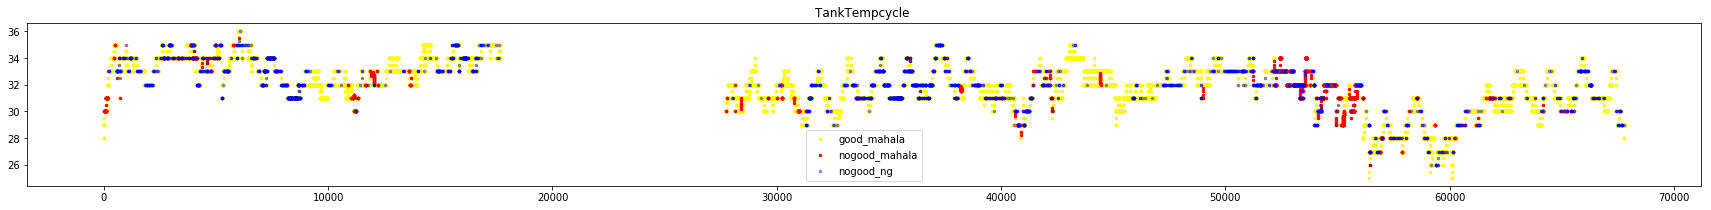

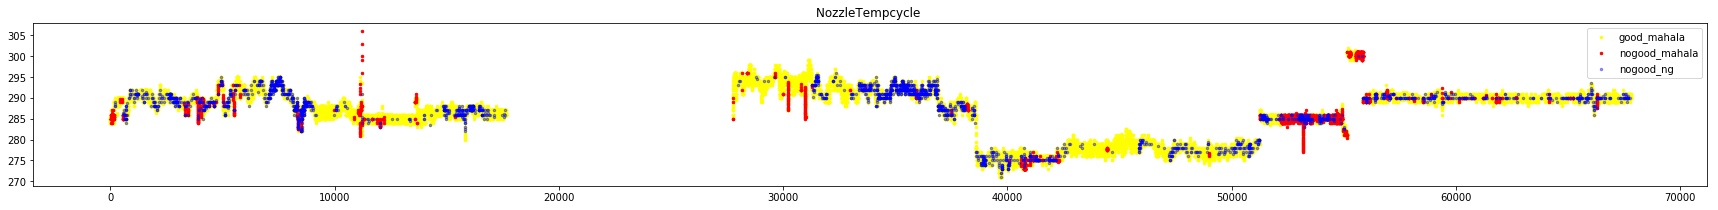

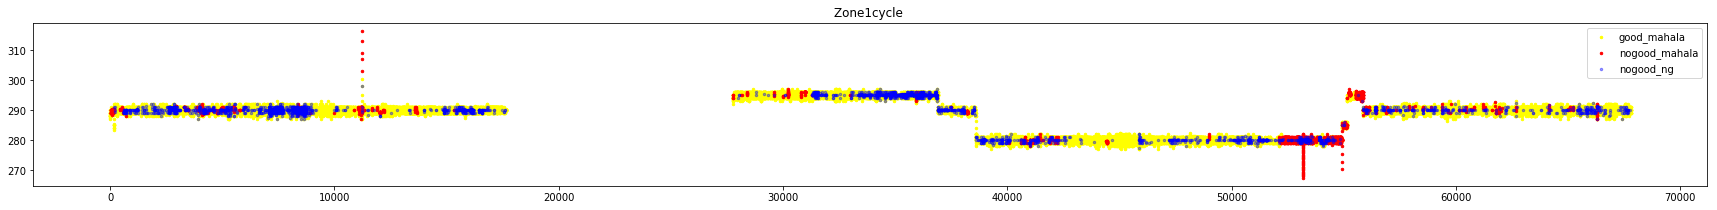

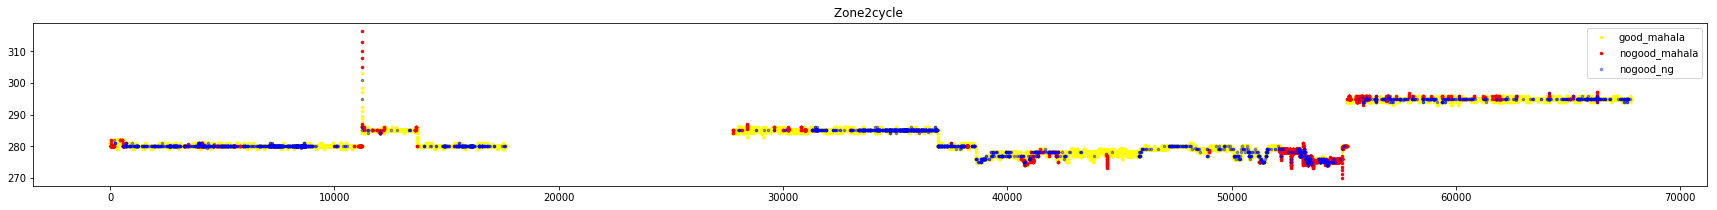

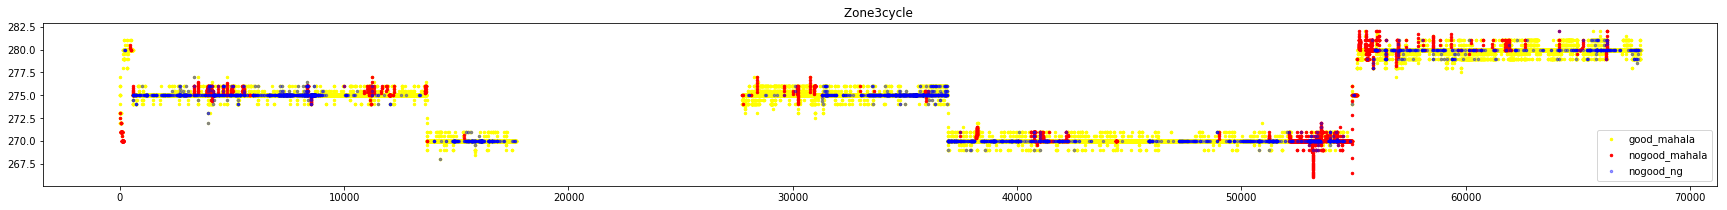

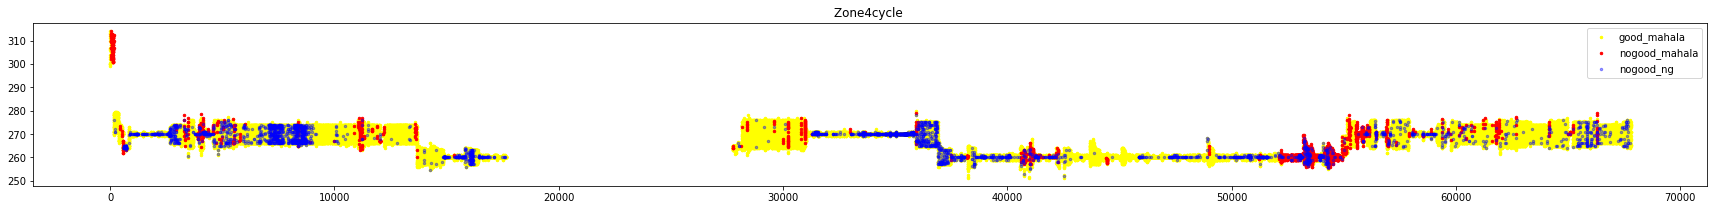

In [19]:
df_name = df
#cycle_num = cycle_num
NG_target = 'mahala_label'

for i in range(len(analy_col)):
    fig, ax1 = plt.subplots(1,1, sharey=True, figsize=(30,3))
    #ax1.plot(df_name[df_name[NG_target]==0][analy_col[i]], color='y', label='good', alpha=0.5)
    ax1.scatter(df_name[df_name[NG_target]==0][analy_col[i]].index, df_name[df_name[NG_target]==0][analy_col[i]], color='yellow', label='good_mahala', s=6)
    ax1.scatter(df_name[df_name[NG_target]==1][analy_col[i]].index, df_name[df_name[NG_target]==1][analy_col[i]], color='r', label='nogood_mahala', s=6)
    ax1.scatter(df_name[df_name['NG']==1][analy_col[i]].index, df_name[df_name['NG']==1][analy_col[i]], color='blue', label='nogood_ng', s=6, alpha=0.4)
    ax1.legend()
    ax1.set_title(analy_col[i]+'cycle ') # + str(cycle_num)

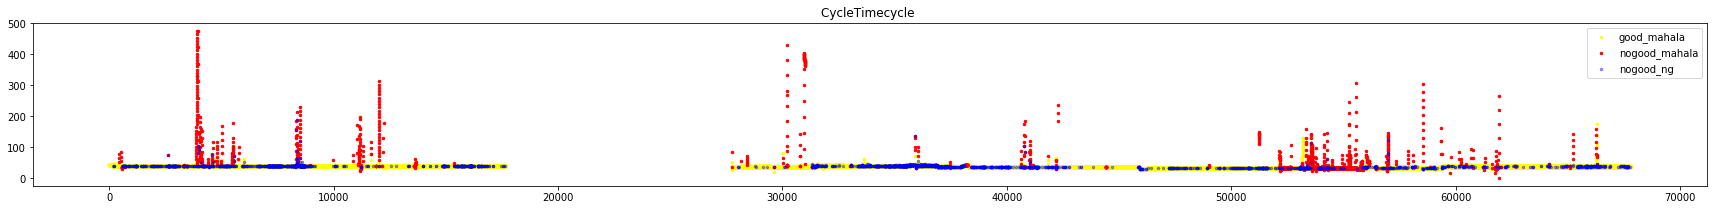

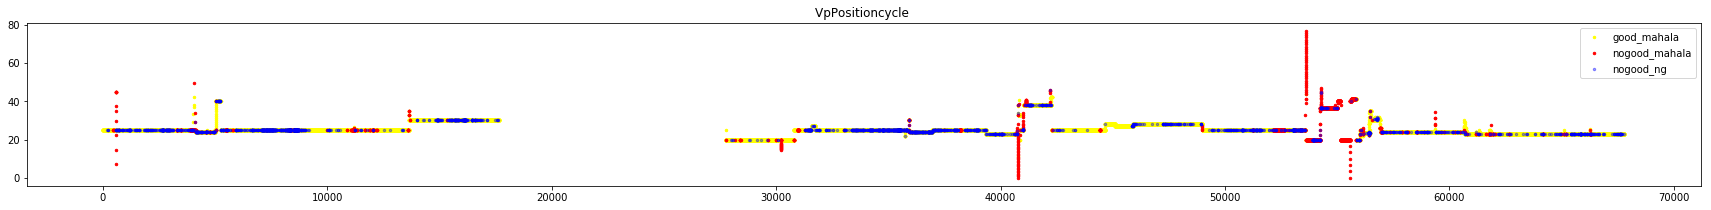

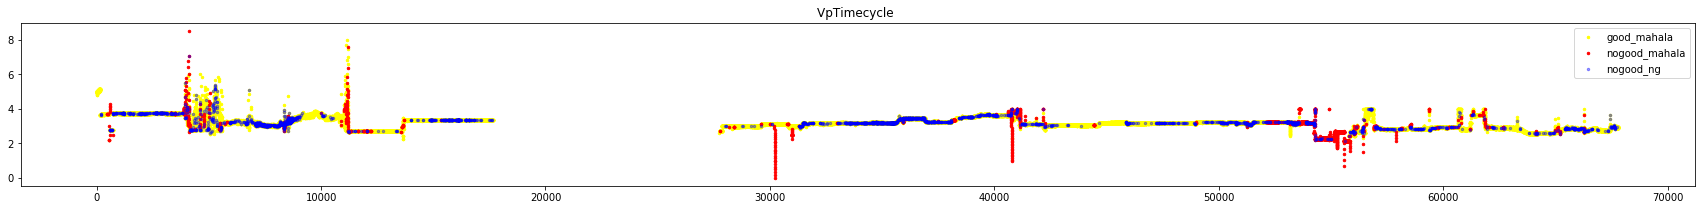

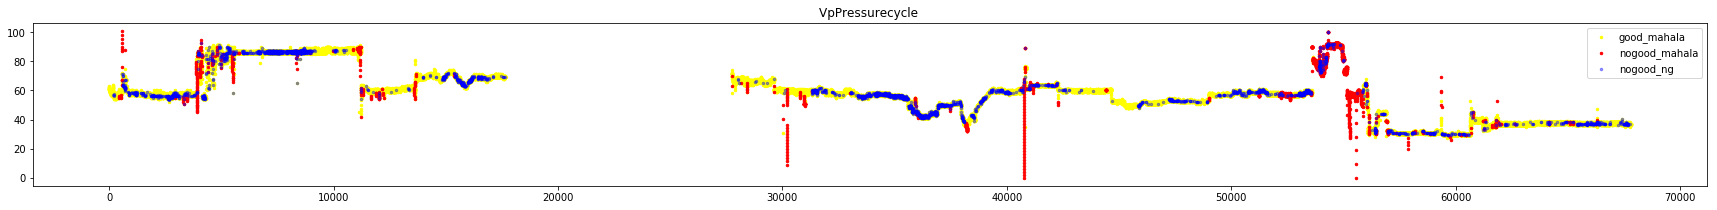

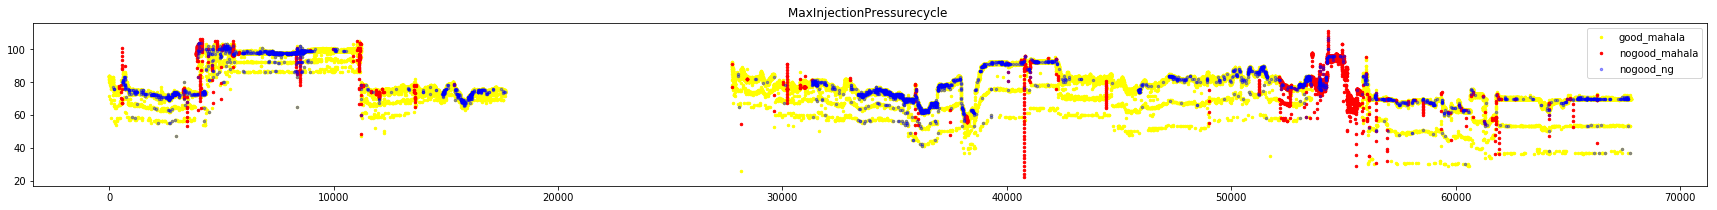

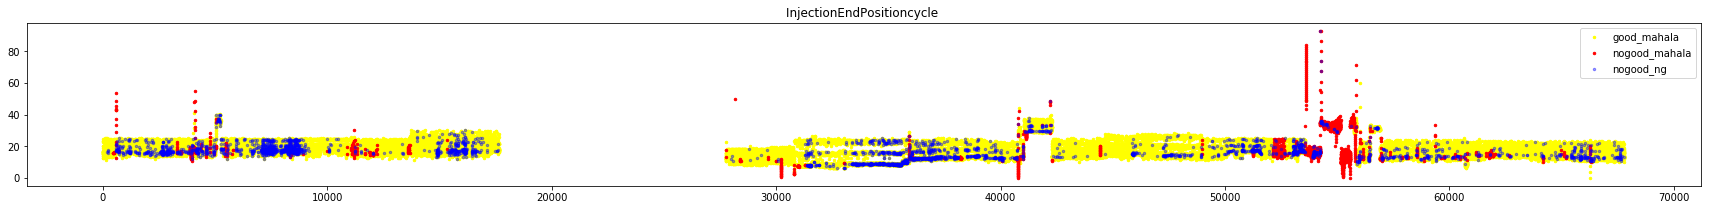

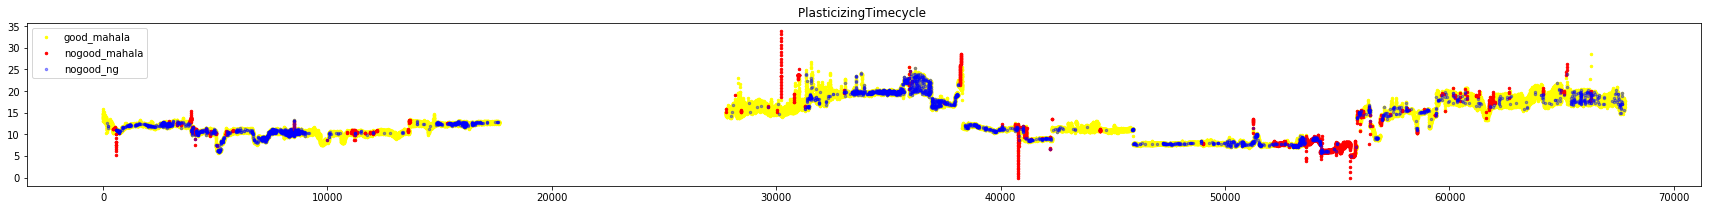

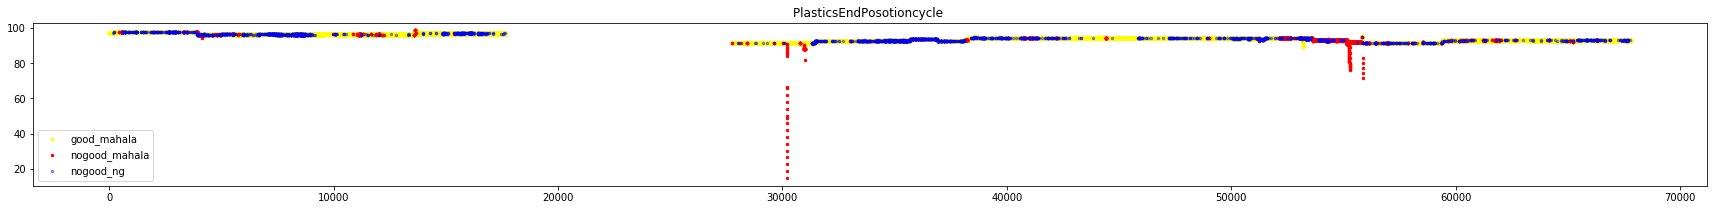

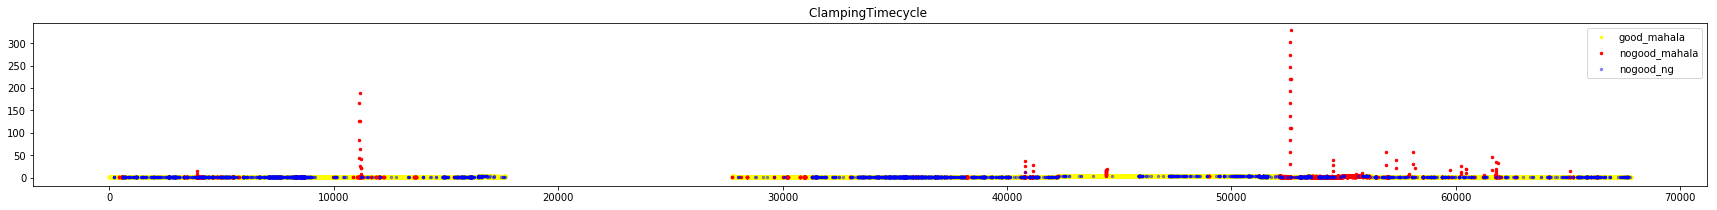

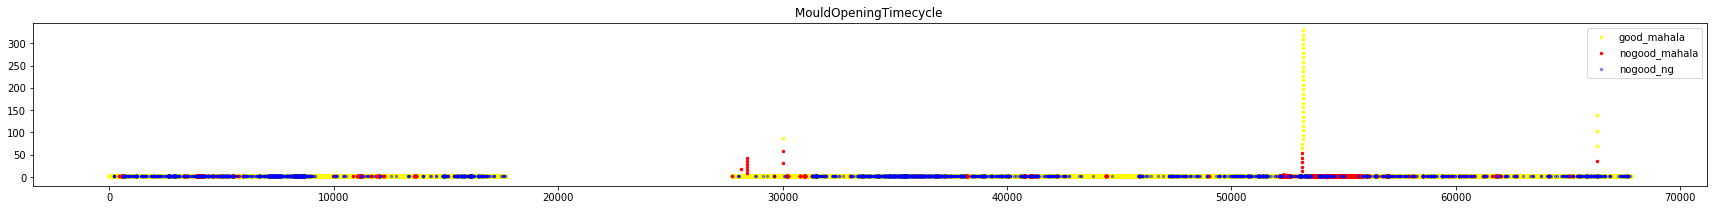

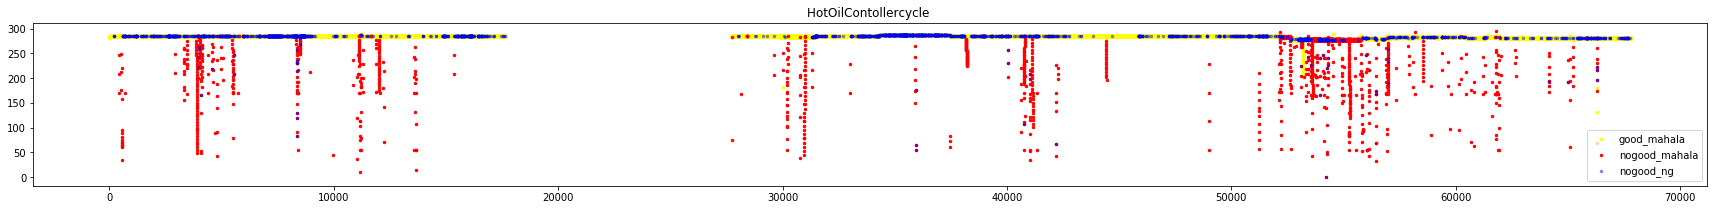

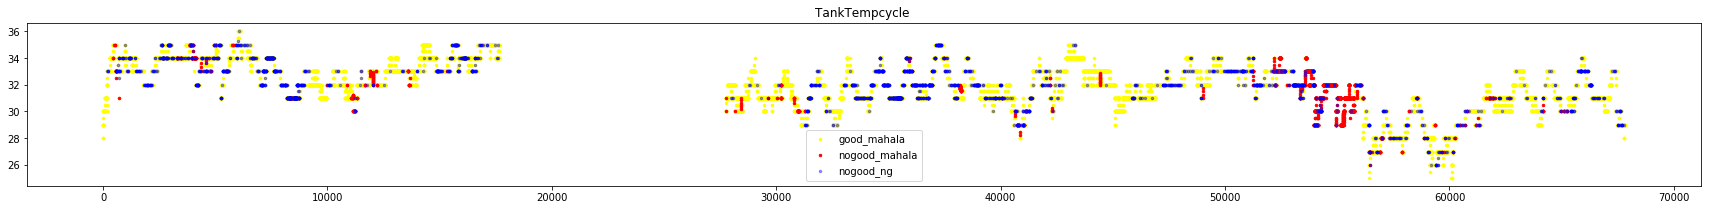

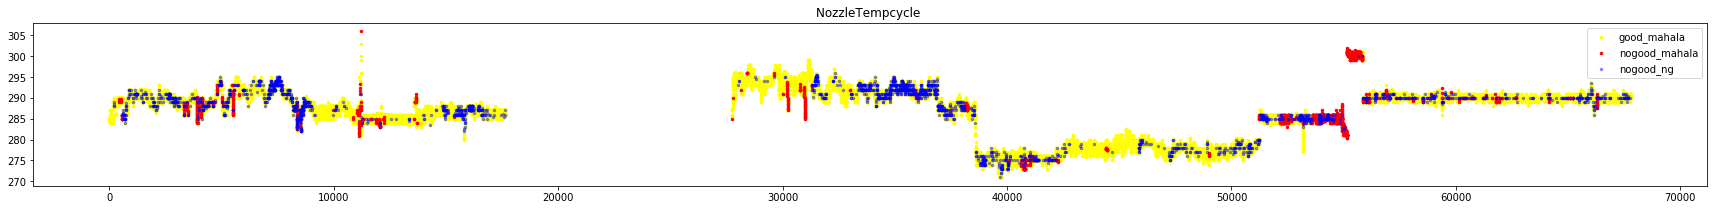

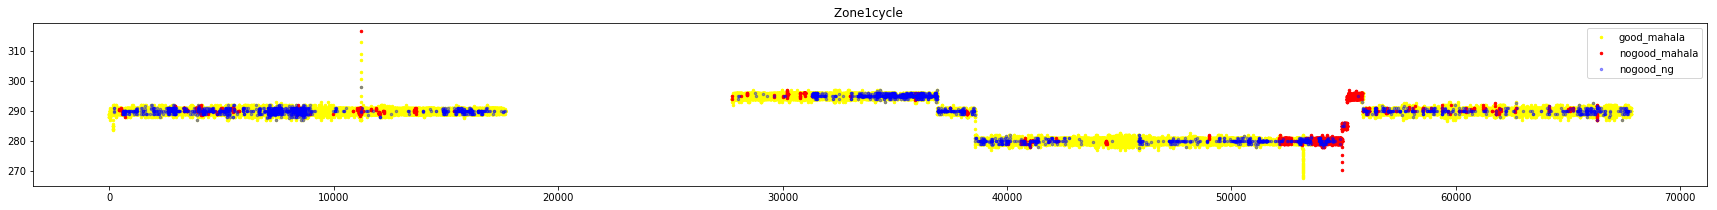

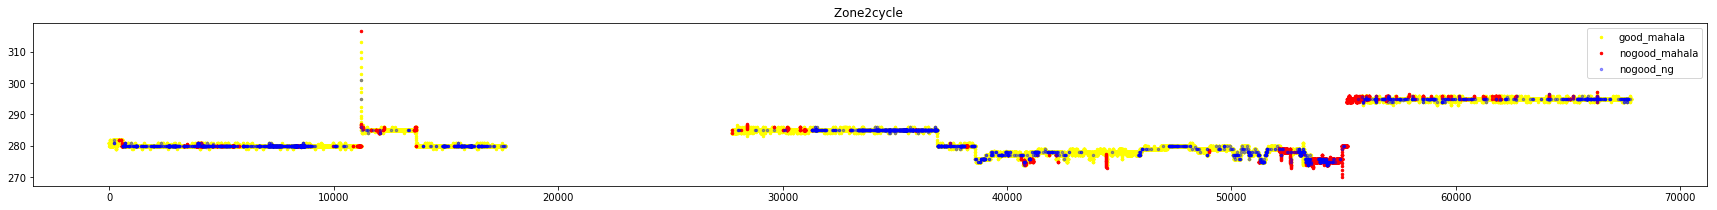

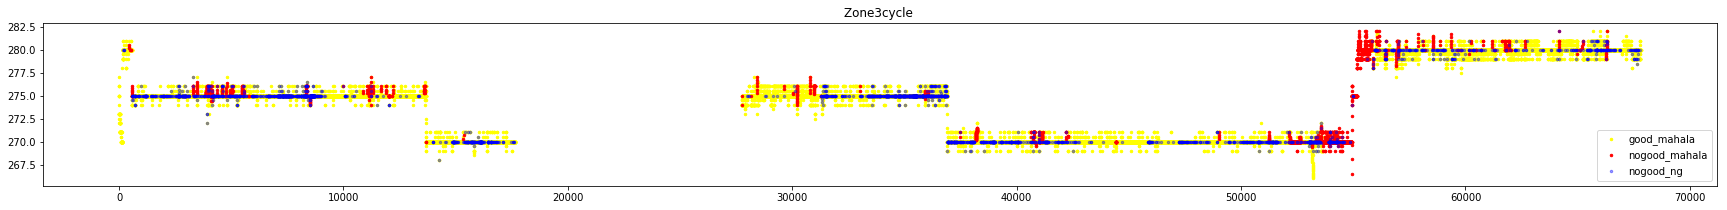

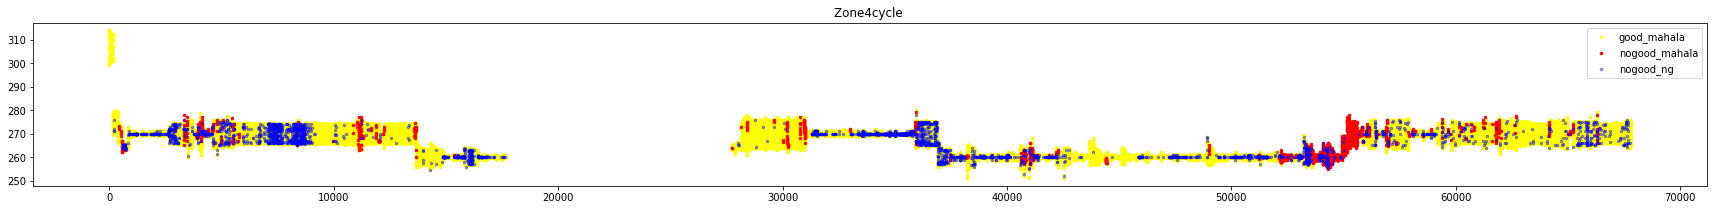

In [20]:
df_name = df
#cycle_num = cycle_num
NG_target = 'K_mahala_label'

for i in range(len(analy_col)):
    fig, ax1 = plt.subplots(1,1, sharey=True, figsize=(30,3))
    #ax1.plot(df_name[df_name[NG_target]==0][analy_col[i]], color='y', label='good', alpha=0.5)
    ax1.scatter(df_name[df_name[NG_target]==0][analy_col[i]].index, df_name[df_name[NG_target]==0][analy_col[i]], color='yellow', label='good_mahala', s=6)
    ax1.scatter(df_name[df_name[NG_target]==1][analy_col[i]].index, df_name[df_name[NG_target]==1][analy_col[i]], color='r', label='nogood_mahala', s=6)
    ax1.scatter(df_name[df_name['NG']==1][analy_col[i]].index, df_name[df_name['NG']==1][analy_col[i]], color='blue', label='nogood_ng', s=6, alpha=0.4)
    ax1.legend()
    ax1.set_title(analy_col[i]+'cycle ') # + str(cycle_num)

- mahala0_df : 마할라 라벨 정상으로만 구성한 데이터 프레임

In [28]:
mahala0_df = df[df.mahala_label==0][analy_col]
rb_scaler = RobustScaler()
normal_scaled_X = rb_scaler.fit_transform(mahala0_df)

mahala1_df = df[df.mahala_label==1][analy_col]
abnormal_scaled_X = rb_scaler.transform(mahala1_df)

## LOF

- outlier detection

In [22]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(novelty=False, contamination=prop)
y_pred = lof.fit_predict(scaled_X)
y_pred = [1 if x == -1 else 0 for x in y_pred]
df['lof_label']= y_pred

C:\Users\ARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### GMM

In [23]:
from sklearn import mixture

g = mixture.GaussianMixture(n_components=15, random_state=2019, covariance_type='full')
gmm = g.fit(scaled_X) 
df['gmm_score']=gmm.score_samples(scaled_X)

C:\Users\ARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


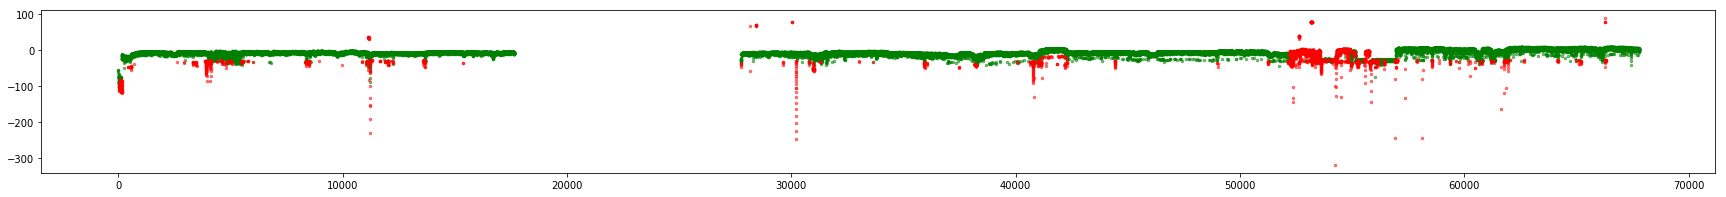

In [24]:
target_col = 'mahala_label'

plt.figure(figsize=(30,3))
plt.scatter(df[df[target_col]==0]['gmm_score'].index, df[df[target_col]==0]['gmm_score'], c='g', alpha=0.5, s=6)
plt.scatter(df[df[target_col]==1]['gmm_score'].index, df[df[target_col]==1]['gmm_score'], c='r', alpha=0.5, s=6)

In [25]:
k = sorted(df.gmm_score.values, reverse=False)
t = np.ceil(len(df)*prop).astype(int)

gmm_label = []
for x in df['gmm_score'].values:
    if x> k[t]: gmm_label.append(0)
    else: gmm_label.append(1)

df['gmm_label'] = gmm_label

C:\Users\ARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### IF

In [26]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(behaviour='new', max_samples=100, random_state=42, contamination=prop)
y_pred = model.fit_predict(scaled_X)

y_pred = [1 if x == -1 else 0 for x in y_pred]
df['IF_label']= y_pred

C:\Users\ARA\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


### One Class SVM

In [ ]:
from sklearn import svm

clf = svm.OneClassSVM(nu=prop, kernel='rbf')
clf.fit(normal_scaled_X)

y_pred = clf.predict(scaled_X)

y_pred = [1 if x == -1 else 0 for x in y_pred]
df['svm_label']= y_pred

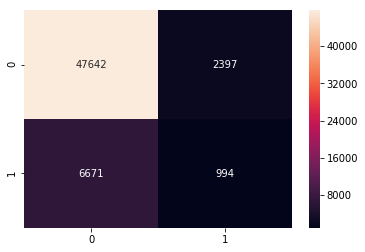

In [30]:
### plot confusion matrix
label = 'svm_label'
df_cm = pd.DataFrame(confusion_matrix(df[label], df['lof_label']))
plt.figure()
sn.heatmap(df_cm, annot=True, fmt='d')

In [31]:
print(classification_report(df[label], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50039
           1       1.00      1.00      1.00      7665

   micro avg       1.00      1.00      1.00     57704
   macro avg       1.00      1.00      1.00     57704
weighted avg       1.00      1.00      1.00     57704



In [32]:
print("mahala: ", df[(df.mahala_label ==1)].shape[0])
print("K_mahala: ", df[(df.K_mahala_label ==1)].shape[0])
print("gmm: ", df[(df.gmm_label ==1)].shape[0])
print("IF: ", df[(df.IF_label ==1)].shape[0])
print("LOF: ", df[(df.lof_label ==1)].shape[0])
print("mahala, K_mahala: ", df[(df.mahala_label ==1) & (df.K_mahala_label ==1)].shape[0])
print("mahala, gmm: ", df[(df.mahala_label ==1) & (df.gmm_label ==1)].shape[0])
print("mahala, IF: ", df[(df.mahala_label ==1) & (df.IF_label ==1)].shape[0])
print("mahala, LOF: ", df[(df.mahala_label ==1) & (df.lof_label ==1)].shape[0])
print("gmm, IF : ", df[(df.gmm_label ==1) & (df.IF_label ==1)].shape[0])
print("gmm, LOF: ", df[(df.gmm_label ==1) & (df.lof_label ==1)].shape[0])
print("IF, LOF: ", df[(df.IF_label ==1) & (df.lof_label ==1)].shape[0])
print("mahala, gmm, IF, LOF: ", df[(df.mahala_label ==1) & (df.gmm_label ==1) & (df.IF_label ==1) & (df.lof_label ==1)].shape[0])
print("mahala, K_mahala, gmm, IF, LOF 모두 정상 : ", df[(df.mahala_label ==0) & (df.K_mahala_label ==1) & (df.gmm_label ==0) & (df.IF_label ==0) & (df.lof_label ==0)].shape[0])
print("전체 data 개수: ", len(df))

mahala:  3392
K_mahala:  3392
gmm:  3392
IF:  3391
LOF:  3391
mahala, K_mahala:  2251
mahala, gmm:  1467
mahala, IF:  1814
mahala, LOF:  355
gmm, IF :  1802
gmm, LOF:  596
IF, LOF:  426
mahala, gmm, IF, LOF:  159
mahala, K_mahala, gmm, IF, LOF 모두 정상 :  366
전체 data 개수:  57704


In [33]:
df = df.drop(['gmm_score'], axis=1)
df['combined_label'] = df['mahala_label'] + df['K_mahala_label'] + df['lof_label'] + df['gmm_label'] + df['IF_label'] 

In [34]:
#df.to_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label.csv', index=False)